In [798]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
import json
import folium
import seaborn as sns
from sklearn.linear_model import LinearRegression

## Binning courses

In [800]:
# Reading the dataframe
CD = pd.read_excel("DataFrame.xlsx", dtype={'Course code': str})

In [801]:
#Correcting some errors in the data set
CD.loc[115,"Course name"] = "Staging co-creation and creativity"
CD.loc[CD["Course name"] == "Facilitating Innovation in Multidisciplinary teams", "Course name"] = "Facilitating Innovation in Multidisciplinary Teams"

In [802]:
# Adding a column for learning categories
CD[["Category"]] = ""

In [803]:
pd.set_option('display.max_rows', None) #df viewing options

In [804]:
#Assigning courses to different learning categories
managementAndBusiness=['42071','42502','02492','42879','42634','42577','42575','42436','42435','42430','42387','42351',"42433",'42085','42383','42388','42389','42421','25352','38106','38113','42009','42196','42107','42438','42415','42105','42543','38301','38302','42016','41073','42490','42576','42386']
medtec=['22435','27002','22475','22449','23531','22284','02455']
manufacturingAndMaterials=['10316','34052','41744','41653','41733','28244','41347','11909','31300','41501','41514','41665','41511','10862','41528','41735','41659','41749','46420','41656','41655','41739']
designforpeople=['22700','42554','42081',"02266",'42893','41072','42090','10605','42373']
supplychain=['42371','42402','41740','42587','42101','42380','42370']
productdesign=['41612','41742','47203','10750','41078','41618','41031','41342','46797','02809','41084','41628','41743','42087','38109','41635','41737','41512']
systemsengineering=['11337','42452','42451','42083','02431','42270','41061','42282','41083']
circularitySustainability=['12240','12130','42390','42372','28870','12132','12139','12104','25301','47202','12111','12250','30755','22281','42378','42391','12143','12205','12211','12773','12953','23532','27510','38001','12701','41051','12605','41636','12105','23552','42340','42014']
SmartProducts=['42115','34366',"02830",'31383','34338','34540','34367','34723','02564','02160','31375','31392','41028','31385','34365','02170','31070','31386','34346','02808','34315','34373']
tecnicalCompetences=['02561','02441',"88383","02633","02450",'28213','02805','02162','02402','02003','41525','41822','02403','02102','10420','28864','41522','41571','02411','01035','02105','4165','415289','10603','02393','02502','41615','42417','42610','02806']

category_lists = {
    'Management and Business': list(map(str, managementAndBusiness)),
    'Medtech': list(map(str, medtec)),
    'Manufacturing and Materials': list(map(str, manufacturingAndMaterials)),
    'Design for People': list(map(str, designforpeople)),
    'Supply Chain': list(map(str, supplychain)),
    'Product Design': list(map(str, productdesign)),
    'Systems Engineering': list(map(str, systemsengineering)),
    'Circularity and Sustainability': list(map(str, circularitySustainability)),
    'Smart Products': list(map(str, SmartProducts)),
    'Technical Competences': list(map(str, tecnicalCompetences)) # Not just programming?
}

def find_categories(course):
    return [name for name, codes in category_lists.items() if course in codes]

CD['Category'] = CD['Course code'].apply(find_categories)
CD['Category'] = CD['Category'].apply(lambda x: ', '.join(x))

In [805]:
# If a course has the same name as another that already has a category assigned, the same category will be assigned
# Create a mapping from course name to category where Category is not empty
course_to_category = CD[CD["Category"] != ""].drop_duplicates(subset="Course name").set_index("Course name")["Category"]

# Use the mapping to fill missing categories based on course name
CD["Category"] = CD["Category"].replace("", None)  # replace empty string with actual NaN
CD["Category"] = CD["Category"].fillna(CD["Course name"].map(course_to_category))

In [806]:
# Checks if a courses misses a category
df_missing_category = CD[CD["Category"].isna()]
df_missing_category_unique = df_missing_category.drop_duplicates(subset="Course name", keep="first").reset_index(drop=True)
df_missing_category_unique

,Course code,Course name,Semester,Level,ECTS,Course type,Passed DI students,Passed students,Average grade,Placement,URL,Eval_1.1,Eval_1.2,Eval_1.3,Eval_1.4,Eval_1.5,Eval_2.1,Category


## Evaluations

In [808]:
# Creates a secondary dataframe
df_e = CD.copy()

In [809]:
#Drops rows with NaN in any of the following categories (in this case, there will most likely be insufficient data)
df_e.dropna(subset=['Eval_1.1', 'Eval_1.2', 'Eval_1.3', 'Eval_1.4', 'Eval_1.5', "Passed students"], inplace=True)

In [810]:
# Ordering the semesters and sorts the data in accordance with the newest courses first
semester_order = ["Fall 2024", "Spring 2024",
                 "Fall 2023", "Spring 2023",
                 "Fall 2022", "Spring 2022",
                 "Fall 2021", "Spring 2021",
                 "Fall 2020", "Spring 2020"]
semester_order = pd.Categorical(semester_order, categories=semester_order, ordered=True)

In [811]:
#Sorts out repeating courses by only having the rows of newest passed course
df_e['Semester'] = pd.Categorical(df_e['Semester'], categories=semester_order, ordered=True)
df_e_sorted = df_e.sort_values(by=['Course name', 'Semester'])
df_e = df_e_sorted.drop_duplicates(subset='Course name', keep='first')
df_e = df_e_sorted.drop_duplicates(subset='Course code', keep='first') # sorts out a few errors where the named differed slighly, but the course code is the same

In [812]:
# Creating a general evaluation score, excluding Eval_2.1 that doesnt concern the quality of the course but the time it requires
df_e["Evaluation"] = df_e[["Eval_1.1", "Eval_1.2", "Eval_1.3", "Eval_1.4", "Eval_1.5"]].mean(axis=1)

/var/folders/xl/ml65d5zn6dg23p6nqskls4dm0000gn/T/ipykernel_6688/1691583125.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_e["Evaluation"] = df_e[["Eval_1.1", "Eval_1.2", "Eval_1.3", "Eval_1.4", "Eval_1.5"]].mean(axis=1)


In [813]:
# Drops unnnesecary columns
df_e = df_e.drop(columns = ["Eval_1.1", "Eval_1.2", "Eval_1.3", "Eval_1.4", "Eval_1.5", "Eval_2.1"])

In [814]:
# Rounds the evaluation score to two decimals
df_e["Evaluation"] = round(df_e["Evaluation"], 2)

In [815]:
# adds a column for the percentage of passed DI msc. students in a course
df_e["Passed fraction"] = ""

In [816]:
# Assigns values for the percentage of passed DI msc. students to each course
for i in range(len(df_e)):
    di_val = df_e.iloc[i]["Passed DI students"]

    if di_val == "<=5":
        di_val_numeric = float(5.0) # if Passed DI students is anonymized data (<=5), it is set to 5
        passed_total = df_e.iloc[i]["Passed students"]
        df_e.loc[df_e.index[i], "Passed fraction"] = round((di_val_numeric / passed_total) * 100, 2)

    else:
        di_val_numeric = float(di_val)
        passed_total = df_e.iloc[i]["Passed students"]
        df_e.loc[df_e.index[i], "Passed fraction"] = round((di_val_numeric / passed_total) * 100, 2)


In [817]:
# makes the passed faction a float
df_e["Passed fraction"] = df_e["Passed fraction"].astype(float)

In [818]:
# Sorts rows in accordance to their passed fraction value
df_e = df_e.sort_values(by='Passed fraction', ascending=True)

In [819]:
# Resets the row index
df_e = df_e.reset_index(drop=True)

### Tap tool (Bokeh plot)

In [821]:
from bokeh.io import output_file, show, save
from bokeh.layouts import column, row
from bokeh.models import ColumnDataSource, Range1d, WheelZoomTool, Div, CustomJS, FactorRange, TapTool, Legend, LegendItem
from bokeh.plotting import figure
from bokeh.palettes import Category20

In [822]:
# Ensures that there is only one learnign category assigned to each course
df_e_category = df_e.copy()
df_e_category["Category_single"] = df_e["Category"].str.split(",").str[0].str.strip()
categories = df_e_category["Category_single"].unique()

# Assigns a color to each category
palette = Category20[len(categories)] if len(categories) <= 20 else Category20[20]
color_map = dict(zip(categories, palette))
df_e_category["color"] = df_e_category["Category_single"].map(color_map)

In [823]:
# Create ColumnDataSources
all_source = ColumnDataSource(df_e_category)

# Creates figure
p = figure(title="Course Selection Tool",
           y_axis_label='Evaluation score [0-5]',
           x_axis_label="D&I Msc. students per course [%]",
           y_range=Range1d(2, 5),
           x_range=Range1d(-4, 104),
           width=1000,
           height=600,
           tools="tap,pan,reset,wheel_zoom")

# Pre-activates wheelzoom
p.toolbar.active_scroll = p.select_one(WheelZoomTool)


font_family = "Arial"
# Adjust title font size and style
p.title.text_font_size = "20pt"  # Increase title font size
p.title.text_font_style = "bold"  # Make title bold
p.title.text_font = font_family  # Change title font (optional)

# Adjust axis labels font size and style
p.xaxis.axis_label_text_font_size = "14pt"  # X-axis label size
p.yaxis.axis_label_text_font_size = "14pt"  # Y-axis label size
p.xaxis.axis_label_text_font_style = "normal"  # X-axis label style
p.yaxis.axis_label_text_font_style = "normal"  # Y-axis label style
p.xaxis.axis_label_text_font = font_family  # X-axis label font (optional)
p.yaxis.axis_label_text_font = font_family  # Y-axis label font (optional)

# Adjust tick labels font size
p.xaxis.major_label_text_font_size = "12pt"  # X-axis tick labels
p.yaxis.major_label_text_font_size = "12pt"  # Y-axis tick labels
p.yaxis.major_label_text_font = font_family
p.yaxis.major_label_text_font = font_family
p.xaxis.visible = True

# Div to display course info
div = Div(text="<hr><b>Click on a course dot to see details</b>", width=800)
div.styles = {"margin-left": "65px", 'font-size': '16px', 'font-family': font_family}

# Callbacks that are shown when the dots are clicked
callback = CustomJS(args=dict(source=None, div=div), code="""
    const indices = source.selected.indices;
    if (indices.length > 0) {
        const i = indices[0];
        const course = source.data['Course code'][i];
        const score = source.data['Evaluation'][i];
        const category = source.data['Category'][i];
        const grade = source.data['Average grade'][i];
        const ects = source.data['ECTS'][i];
        const fraction = source.data['Passed fraction'][i];
        const name = source.data['Course name'][i];
        const type = source.data['Course type'][i];
        const place = source.data['Placement'][i];
        const level = source.data['Level'][i];
        const url = source.data['URL'][i];
        div.text = `<hr>
                    <b style="font-family: 'Arial', sans-serif; font-size: 20px;">Course name:</b> <span style="font-family: 'Arial', sans-serif; font-size: 20px;">${name}</span> <br>
                    <b style="font-family: 'Arial', sans-serif; font-size: 14px;">Course code:</b> <span style="font-family: 'Arial', sans-serif; font-size: 14px;">${course}</span> <br>
                    <b style="font-family: 'Arial', sans-serif; font-size: 14px;">URL:</b> <a href="${url}" target="_blank" style="font-family: 'Arial', sans-serif; font-size: 14px;">${url}</a> <br>
                    <hr>
                    <b style="font-family: 'Arial', sans-serif; font-size: 14px;">Evaluation score (0-5):</b> <span style="font-family: 'Arial', sans-serif; font-size: 14px;">${score}</span> <br>
                    <b style="font-family: 'Arial', sans-serif; font-size: 14px;">Percentage of D&I students:</b> <span style="font-family: 'Arial', sans-serif; font-size: 14px;">${fraction}</span> <br>
                    <b style="font-family: 'Arial', sans-serif; font-size: 14px;">Average grade:</b> <span style="font-family: 'Arial', sans-serif; font-size: 14px;">${grade}</span> <br>
                    <hr>
                    <b style="font-family: 'Arial', sans-serif; font-size: 14px;">Learning category:</b> <span style="font-family: 'Arial', sans-serif; font-size: 14px;">${category}</span> <br>
                    <b style="font-family: 'Arial', sans-serif; font-size: 14px;">Course type:</b> <span style="font-family: 'Arial', sans-serif; font-size: 14px;">${type}</span> <br>
                    <b style="font-family: 'Arial', sans-serif; font-size: 14px;">ECTS:</b> <span style="font-family: 'Arial', sans-serif; font-size: 14px;">${ects}</span> <br>
                    <b style="font-family: 'Arial', sans-serif; font-size: 14px;">Placement:</b> <span style="font-family: 'Arial', sans-serif; font-size: 14px;">${place}</span> <br>
                    <b style="font-family: 'Arial', sans-serif; font-size: 14px;">Course Level:</b> <span style="font-family: 'Arial', sans-serif; font-size: 14px;">${level}</span> <br>
                    `;
    }
""")



p.renderers = []

#renaming categories (outdated)
category_name_mapping = {
    'designforpeople': 'Design for People',
    'manufacturingAndMaterials': 'Manufacturing & Materials',
    'managementAndBusiness': 'Management & Business',
    'systemsengineering': 'Systems Engineering',
    'circularitySustainability': 'Circularity & Sustainability',
    'productdesign': 'Product Design',
    'supplychain': 'Supply Chain',
    'SmartProducts': 'Smart Products',
    'tecnicalCompetences': 'Technical Competences',
    'medtec': 'MedTech',
}

legend_items = []

# Defines the learning category dependent scatterplots
for cat in categories:
    sub_df = df_e_category[df_e_category["Category_single"] == cat]
    sub_source = ColumnDataSource(sub_df)
    color = color_map[cat]
    legend_label = category_name_mapping.get(cat, cat)

    renderer = p.scatter(
        x='Passed fraction', y='Evaluation', source=sub_source,
        color=color, size=8, alpha=0.6, marker="circle"
    )

    legend_items.append((legend_label, [renderer]))

    # Set callback
    sub_source.selected.js_on_change('indices', CustomJS(args=dict(source=sub_source, div=div), code=callback.code))

# Legend
legend = Legend(items=legend_items, title="Learning Categories",
                label_text_font=font_family,  # Legend label font
                label_text_font_size="12pt",  # Legend label font size
                title_text_font=font_family,  # Legend title font
                title_text_font_size="14pt",  # Legend title font size
                title_text_font_style="bold",  # Legend title font style
                click_policy="hide")
p.add_layout(legend, 'right')

# Final layout and display
layout = column(p, div)
output_file("Evaluation_plot.html")
show(layout)
save(layout)

'/Users/svend/Alex-Nielsen-manden.github.io/Data load/Evaluation_plot.html'

#### Tool for semi-electives

In [825]:
# Creates a df for only semi-elective courses
df_e_semi = df_e_category.copy()
df_e_semi = df_e_semi[df_e_semi['Course type'] == 'Semi-Elective']

In [826]:
#Creates the same plot but only for semi-elective courses

# Create ColumnDataSources
all_source = ColumnDataSource(df_e_semi)

# Create figure
p = figure(title="Semi-Elective Course Selection Tool",
           y_axis_label='Evaluation score [0-5]',
           x_axis_label="D&I Msc. students per course [%]",
           y_range=Range1d(2, 5),
           x_range=Range1d(-4, 104),
           width=1000,
           height=600,
           tools="tap,pan,reset,wheel_zoom")

p.toolbar.active_scroll = p.select_one(WheelZoomTool)

font_family = "Arial"
# Adjust title font size and style
p.title.text_font_size = "20pt"  # Increase title font size
p.title.text_font_style = "bold"  # Make title bold
p.title.text_font = font_family  # Change title font (optional)

# Adjust axis labels font size and style
p.xaxis.axis_label_text_font_size = "14pt"  # X-axis label size
p.yaxis.axis_label_text_font_size = "14pt"  # Y-axis label size
p.xaxis.axis_label_text_font_style = "normal"  # X-axis label style
p.yaxis.axis_label_text_font_style = "normal"  # Y-axis label style
p.xaxis.axis_label_text_font = font_family  # X-axis label font (optional)
p.yaxis.axis_label_text_font = font_family  # Y-axis label font (optional)

# Adjust tick labels font size
p.xaxis.major_label_text_font_size = "12pt"  # X-axis tick labels
p.yaxis.major_label_text_font_size = "12pt"  # Y-axis tick labels
p.yaxis.major_label_text_font = font_family
p.yaxis.major_label_text_font = font_family
p.xaxis.visible = True

# Div to display course info
div = Div(text="<hr><b>Click on a course dot to see details</b>", width=800)
div.styles = {"margin-left": "65px", 'font-size': '16px', 'font-family': font_family}

# Callbacks that are shown when the dots are clicked
callback = CustomJS(args=dict(source=None, div=div), code="""
    const indices = source.selected.indices;
    if (indices.length > 0) {
        const i = indices[0];
        const course = source.data['Course code'][i];
        const score = source.data['Evaluation'][i];
        const category = source.data['Category'][i];
        const grade = source.data['Average grade'][i];
        const ects = source.data['ECTS'][i];
        const fraction = source.data['Passed fraction'][i];
        const name = source.data['Course name'][i];
        const type = source.data['Course type'][i];
        const place = source.data['Placement'][i];
        const level = source.data['Level'][i];
        const url = source.data['URL'][i];
        div.text = `<hr>
                    <b style="font-family: 'Arial', sans-serif; font-size: 20px;">Course name:</b> <span style="font-family: 'Arial', sans-serif; font-size: 20px;">${name}</span> <br>
                    <b style="font-family: 'Arial', sans-serif; font-size: 14px;">Course code:</b> <span style="font-family: 'Arial', sans-serif; font-size: 14px;">${course}</span> <br>
                    <b style="font-family: 'Arial', sans-serif; font-size: 14px;">URL:</b> <a href="${url}" target="_blank" style="font-family: 'Arial', sans-serif; font-size: 14px;">${url}</a> <br>
                    <hr>
                    <b style="font-family: 'Arial', sans-serif; font-size: 14px;">Evaluation score (0-5):</b> <span style="font-family: 'Arial', sans-serif; font-size: 14px;">${score}</span> <br>
                    <b style="font-family: 'Arial', sans-serif; font-size: 14px;">Percentage of D&I students:</b> <span style="font-family: 'Arial', sans-serif; font-size: 14px;">${fraction}</span> <br>
                    <b style="font-family: 'Arial', sans-serif; font-size: 14px;">Average grade:</b> <span style="font-family: 'Arial', sans-serif; font-size: 14px;">${grade}</span> <br>
                    <hr>
                    <b style="font-family: 'Arial', sans-serif; font-size: 14px;">Learning category:</b> <span style="font-family: 'Arial', sans-serif; font-size: 14px;">${category}</span> <br>
                    <b style="font-family: 'Arial', sans-serif; font-size: 14px;">Course type:</b> <span style="font-family: 'Arial', sans-serif; font-size: 14px;">${type}</span> <br>
                    <b style="font-family: 'Arial', sans-serif; font-size: 14px;">ECTS:</b> <span style="font-family: 'Arial', sans-serif; font-size: 14px;">${ects}</span> <br>
                    <b style="font-family: 'Arial', sans-serif; font-size: 14px;">Placement:</b> <span style="font-family: 'Arial', sans-serif; font-size: 14px;">${place}</span> <br>
                    <b style="font-family: 'Arial', sans-serif; font-size: 14px;">Course Level:</b> <span style="font-family: 'Arial', sans-serif; font-size: 14px;">${level}</span> <br>
                    `;
    }
""")



p.renderers = []

#renaming categories
category_name_mapping = {
    'designforpeople': 'Design for People',
    'manufacturingAndMaterials': 'Manufacturing & Materials',
    'managementAndBusiness': 'Management & Business',
    'systemsengineering': 'Systems Engineering',
    'circularitySustainability': 'Circularity & Sustainability',
    'productdesign': 'Product Design',
    'supplychain': 'Supply Chain',
    'SmartProducts': 'Smart Products',
    'tecnicalCompetences': 'Technical Competences',
    'medtec': 'MedTech',
}

legend_items = []

for cat in categories:
    sub_df = df_e_semi[df_e_semi["Category_single"] == cat]
    sub_source = ColumnDataSource(sub_df)
    color = color_map[cat]
    legend_label = category_name_mapping.get(cat, cat)

    renderer = p.scatter(
        x='Passed fraction', y='Evaluation', source=sub_source,
        color=color, size=8, alpha=0.6, marker="circle"
    )

    legend_items.append((legend_label, [renderer]))

    # Set callback
    sub_source.selected.js_on_change('indices', CustomJS(args=dict(source=sub_source, div=div), code=callback.code))

# Legend
legend = Legend(items=legend_items, title="Learning Categories",
                label_text_font=font_family,  # Legend label font
                label_text_font_size="12pt",  # Legend label font size
                title_text_font=font_family,  # Legend title font
                title_text_font_size="14pt",  # Legend title font size
                title_text_font_style="bold",  # Legend title font style
                click_policy="hide")
p.add_layout(legend, 'right')

# Final layout and display
layout = column(p, div)
output_file("Semi-Elective_Evaluation_plot.html")
show(layout)
save(layout)

'/Users/svend/Alex-Nielsen-manden.github.io/Data load/Semi-Elective_Evaluation_plot.html'

# Narrative

#### Categories and grades

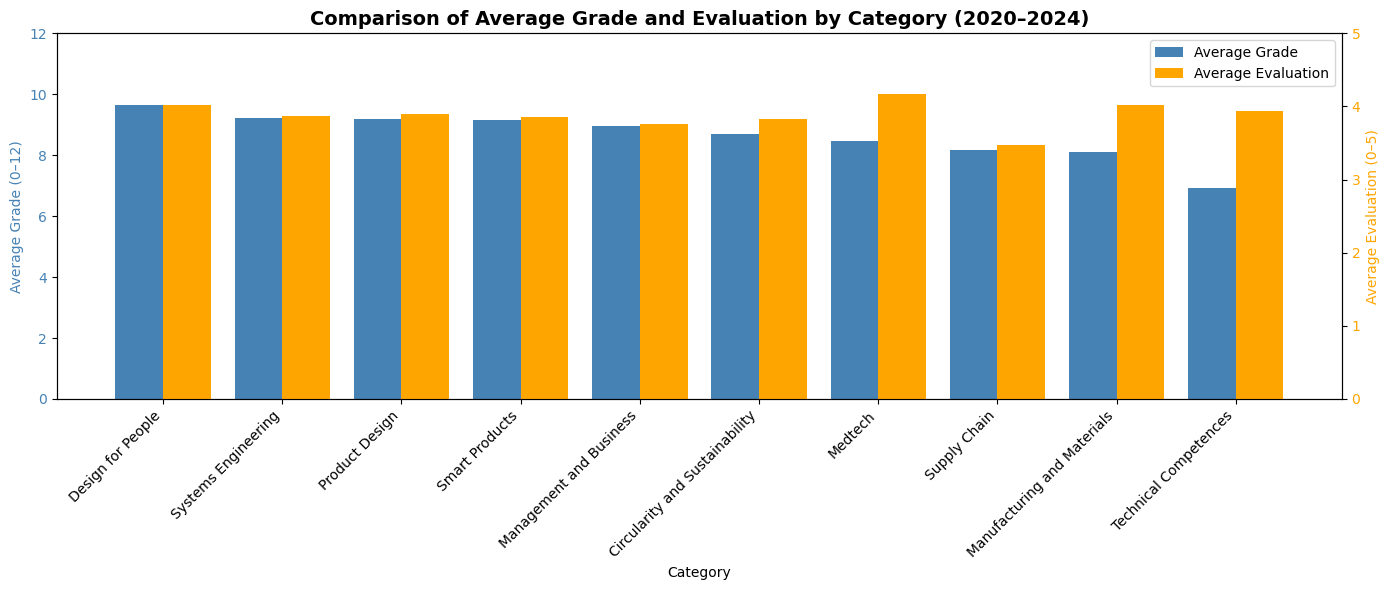

In [829]:
df_n = CD.copy()

# Drop rows with any missing evaluation components
df_n.dropna(subset=['Eval_1.1', 'Eval_1.2', 'Eval_1.3', 'Eval_1.4', 'Eval_1.5'], inplace=True)

# Compute and round evaluation mean
df_n["Evaluation"] = df_n[["Eval_1.1", "Eval_1.2", "Eval_1.3", "Eval_1.4", "Eval_1.5"]].mean(axis=1).round(2)

# Convert grades to numeric and drop rows with missing values
df_n['Average grade'] = pd.to_numeric(df_n['Average grade'], errors='coerce')
df_n.dropna(subset=['Average grade', 'Evaluation'], inplace=True)

# Handle multi-category courses
df_n['Category'] = df_n['Category'].astype(str).str.split(',')
df_n = df_n.explode('Category')
df_n['Category'] = df_n['Category'].str.strip()
df_n = df_n[df_n['Category'].str.lower().isin(['', 'nan', 'none']) == False]

# Compute category-level averages
category_summary = df_n.groupby('Category')[['Average grade', 'Evaluation']].mean().reset_index()

# Prepare for plotting
category_summary = category_summary.sort_values(by='Average grade', ascending=False)
categories = category_summary['Category']
grades = category_summary['Average grade']
ratings = category_summary['Evaluation']
x = np.arange(len(categories))

# Dual-axis bar chart
fig, ax1 = plt.subplots(figsize=(14, 6))
bars1 = ax1.bar(x - 0.2, grades, width=0.4, label='Average Grade', color='steelblue')
ax1.set_ylabel('Average Grade (0–12)', color='steelblue')
ax1.set_ylim(0, 12)
ax1.tick_params(axis='y', labelcolor='steelblue')

ax2 = ax1.twinx()
bars2 = ax2.bar(x + 0.2, ratings, width=0.4, label='Average Evaluation', color='orange')
ax2.set_ylabel('Average Evaluation (0–5)', color='orange')
ax2.set_ylim(0, 5)
ax2.tick_params(axis='y', labelcolor='orange')

ax1.set_xticks(x)
ax1.set_xticklabels(categories, rotation=45, ha='right')
ax1.set_xlabel('Category')
plt.title('Comparison of Average Grade and Evaluation by Category (2020–2024)', fontsize=14,fontweight='bold')

# Combine legends
ax1.legend([bars1, bars2], ['Average Grade', 'Average Evaluation'], loc='upper right')

plt.tight_layout()
plt.show()

## Do the same but only for electives

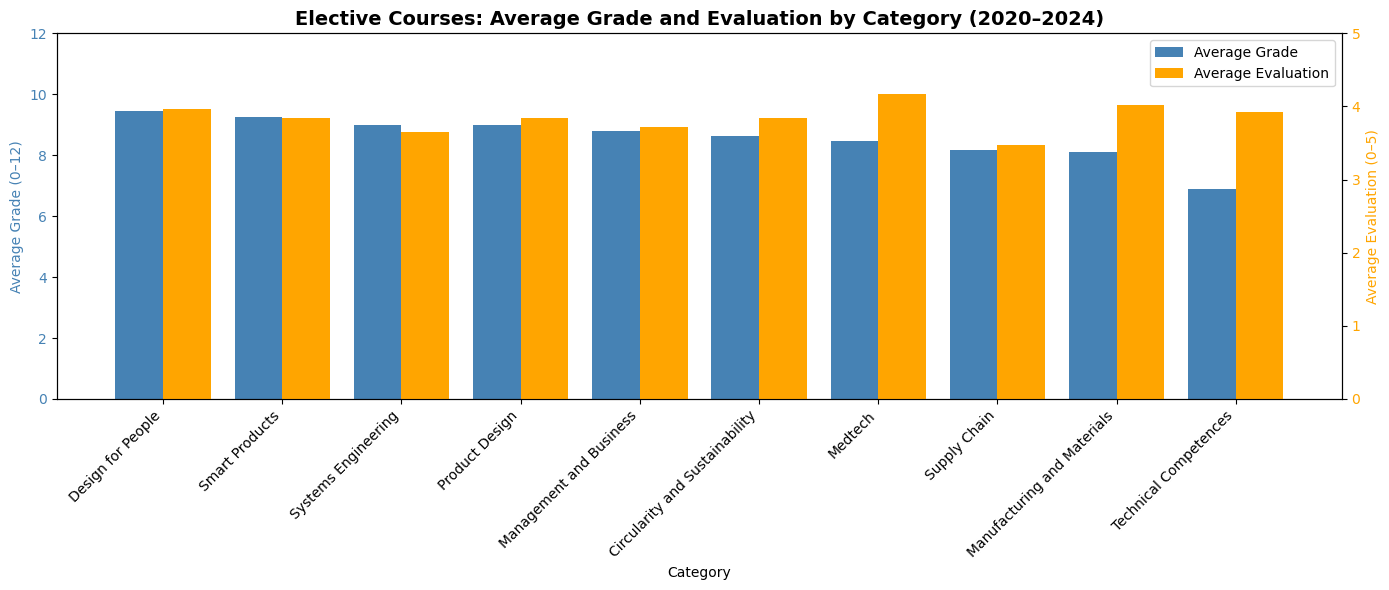

In [831]:
df_n1 = CD.copy()

# Filter for elective courses
df_n1 = df_n1[df_n1['Course type'] == 'Elective']

# Drop rows with any missing evaluation components
df_n1.dropna(subset=['Eval_1.1', 'Eval_1.2', 'Eval_1.3', 'Eval_1.4', 'Eval_1.5'], inplace=True)

# Compute and round evaluation mean
df_n1["Evaluation"] = df_n1[["Eval_1.1", "Eval_1.2", "Eval_1.3", "Eval_1.4", "Eval_1.5"]].mean(axis=1).round(2)

# Convert grades to numeric and drop rows with missing values
df_n1['Average grade'] = pd.to_numeric(df_n1['Average grade'], errors='coerce')
df_n1.dropna(subset=['Average grade', 'Evaluation'], inplace=True)

# Handle multi-category courses
df_n1['Category'] = df_n1['Category'].astype(str).str.split(',')
df_n1 = df_n1.explode('Category')
df_n1['Category'] = df_n1['Category'].str.strip()
df_n1 = df_n1[df_n1['Category'].str.lower().isin(['', 'nan', 'none']) == False]

# Compute category-level averages
category_summary = df_n1.groupby('Category')[['Average grade', 'Evaluation']].mean().reset_index()

# Prepare for plotting
category_summary = category_summary.sort_values(by='Average grade', ascending=False)
categories = category_summary['Category']
grades = category_summary['Average grade']
ratings = category_summary['Evaluation']
x = np.arange(len(categories))

# Dual-axis bar chart
fig, ax1 = plt.subplots(figsize=(14, 6))
bars1 = ax1.bar(x - 0.2, grades, width=0.4, label='Average Grade', color='steelblue')
ax1.set_ylabel('Average Grade (0–12)', color='steelblue')
ax1.set_ylim(0, 12)
ax1.tick_params(axis='y', labelcolor='steelblue')

ax2 = ax1.twinx()
bars2 = ax2.bar(x + 0.2, ratings, width=0.4, label='Average Evaluation', color='orange')
ax2.set_ylabel('Average Evaluation (0–5)', color='orange')
ax2.set_ylim(0, 5)
ax2.tick_params(axis='y', labelcolor='orange')

ax1.set_xticks(x)
ax1.set_xticklabels(categories, rotation=45, ha='right')
ax1.set_xlabel('Category')
plt.title('Elective Courses: Average Grade and Evaluation by Category (2020–2024)', fontsize=14,fontweight='bold')

# Combine legends
ax1.legend([bars1, bars2], ['Average Grade', 'Average Evaluation'], loc='upper right')
ax1.grid(False)
ax2.grid(False)
plt.savefig("elective_grades_evaluation.png", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()

#### Average grade over time

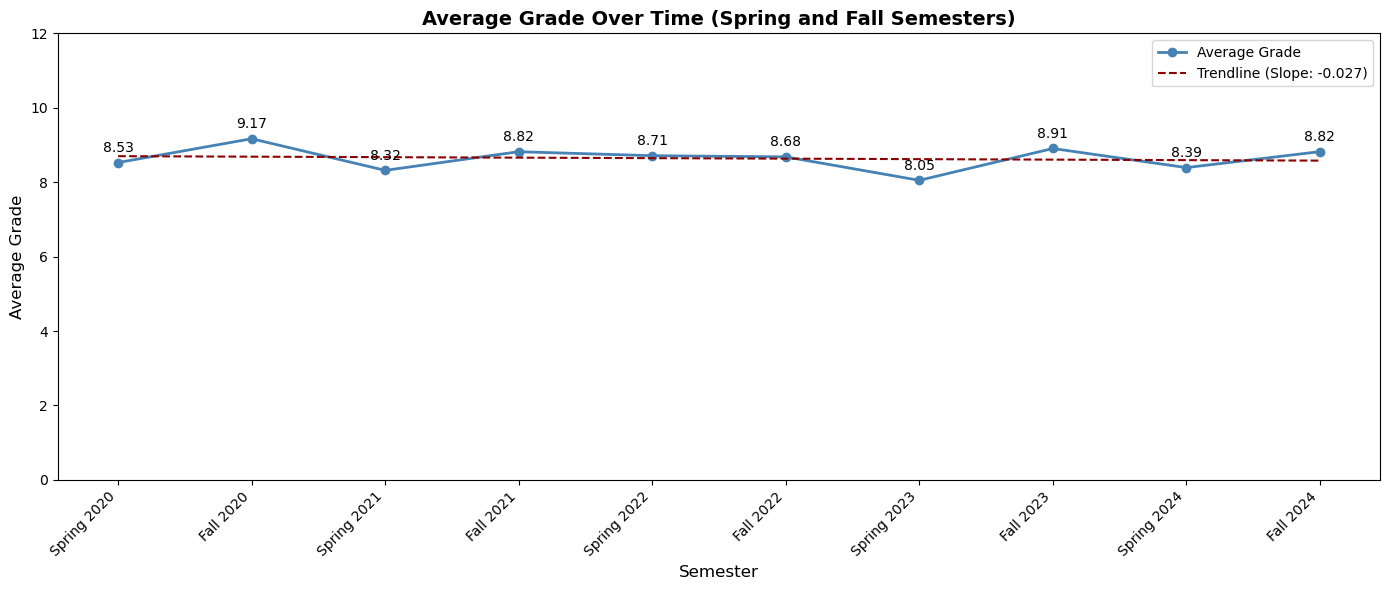

In [833]:
df_n2 = CD.copy()

# Extract the year from the 'Semester' column
df_n2['Year'] = df_n2['Semester'].str.extract(r'(\d{4})').astype(int)

# Exclude 2019 from the DataFrame
df_n2 = df_n2[df_n2['Year'] != 2019]

# Map the semesters (Fall/Spring) to numerical values for sorting
df_n2['Semester_Num'] = df_n2['Semester'].apply(lambda x: 1 if 'Spring' in x else 2)

# Combine 'Year' and 'Semester_Num' into a single time representation
df_n2['Time'] = df_n2['Year'] + (df_n2['Semester_Num'] - 1) * 0.5  # Spring = 0.0, Fall = 0.5

# Convert 'Average grade' to numeric, coercing errors to NaN
df_n2['Average grade'] = pd.to_numeric(df_n2['Average grade'], errors='coerce')

# Drop rows with missing 'Time' or 'Average grade'
df_n2.dropna(subset=['Time', 'Average grade'], inplace=True)

# Group by 'Time' and calculate average grade
grades_over_time = df_n2.groupby('Time')['Average grade'].mean().reset_index()

# Fit a linear regression to show overall trend
model = LinearRegression()
model.fit(grades_over_time['Time'].values.reshape(-1, 1), grades_over_time['Average grade'])

# Predict values from the linear regression model
grades_over_time['Trend'] = model.predict(grades_over_time['Time'].values.reshape(-1, 1))

# Calculate the slope to label the trendline as positive or negative
slope = model.coef_[0]
intercept = model.intercept_

# Create a label for the slope
slope_label = f"Slope: {slope:.3f}"

# Plotting
plt.figure(figsize=(14, 6))

# Plot the average grades over time (original color - blue)
plt.plot(grades_over_time['Time'], grades_over_time['Average grade'], marker='o', color='steelblue', linestyle='-', linewidth=2, label='Average Grade')

# Plot the linear trendline (original color - red)
plt.plot(grades_over_time['Time'], grades_over_time['Trend'], color='darkred', linestyle='--', label=f'Trendline ({slope_label})')

# Title and labels
plt.title('Average Grade Over Time (Spring and Fall Semesters)', fontsize=14,fontweight='bold')
plt.xlabel('Semester', fontsize=12)
plt.ylabel('Average Grade', fontsize=12)

# Set y-axis range from 0 to 12
plt.ylim(0, 12)

# Customize x-ticks to show both semester and year in a cleaner format
x_ticks = grades_over_time['Time']
x_labels = [f"Spring {int(t)}" if t % 1 == 0 else f"Fall {int(t)}" for t in x_ticks]
plt.xticks(x_ticks, labels=x_labels, rotation=45, ha='right', fontsize=10)

# Add data labels on the plot for each point with bold annotation
for i, row in grades_over_time.iterrows():
    plt.text(row['Time'], row['Average grade'] + 0.2, f"{row['Average grade']:.2f}",
             ha='center', va='bottom', fontsize=10, color='black')

# Remove the grid for a cleaner look
plt.grid(False)

# Annotate the trendline with an arrow and label
plt.annotate(f'Trend: {slope_label}', 
             xy=(0.8, 10),  # Position near the trendline (adjust for better visibility)
             xytext=(0.8, 9),  # Slightly shifted to make space for the label
             textcoords='figure fraction',
             fontsize=12,
             ha='center', 
             va='center',
             color='darkred', 
             bbox=dict(facecolor='white', edgecolor='darkred', boxstyle='round,pad=0.3'),
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.3", color='darkred'))

# Show the legend
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()

plt.savefig("average_grade_semester.png", dpi=300, bbox_inches="tight")
# Show the plot
plt.show()

## Only electives

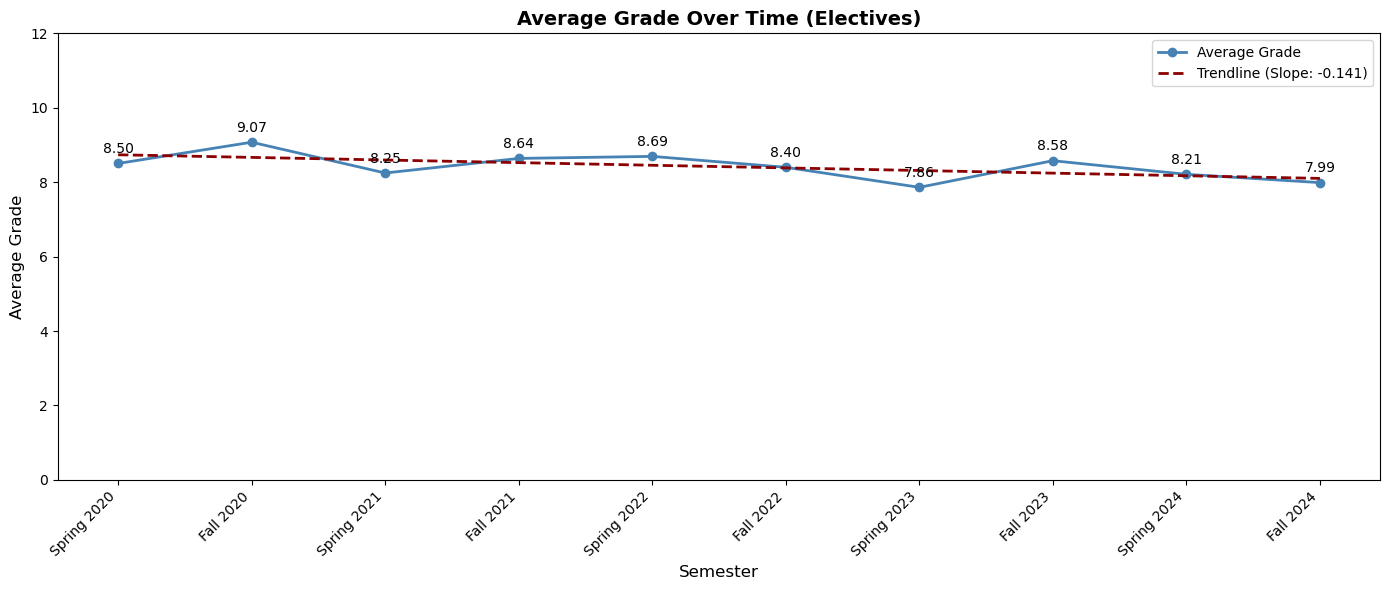

In [835]:
# Copy and filter for electives
df_3 = CD.copy()
df_3 = df_3[df_3['Course type'] == 'Elective']

# Extract the year from the 'Semester' column
df_3['Year'] = df_3['Semester'].str.extract(r'(\d{4})').astype(int)

# Exclude 2019 from the DataFrame
df_3 = df_3[df_3['Year'] != 2019]

# Map the semesters (Fall/Spring) to numerical values for sorting
df_3['Semester_Num'] = df_3['Semester'].apply(lambda x: 1 if 'Spring' in x else 2)

# Combine 'Year' and 'Semester_Num' into a single time representation
df_3['Time'] = df_3['Year'] + (df_3['Semester_Num'] - 1) * 0.5  # Spring = 0.0, Fall = 0.5

# Convert 'Average grade' to numeric, coercing errors to NaN
df_3['Average grade'] = pd.to_numeric(df_3['Average grade'], errors='coerce')

# Drop rows with missing 'Time' or 'Average grade'
df_3.dropna(subset=['Time', 'Average grade'], inplace=True)

# Group by 'Time' and calculate average grade
grades_over_time = df_3.groupby('Time')['Average grade'].mean().reset_index()

# Fit a linear regression to show overall trend
model = LinearRegression()
model.fit(grades_over_time['Time'].values.reshape(-1, 1), grades_over_time['Average grade'])
grades_over_time['Trend'] = model.predict(grades_over_time['Time'].values.reshape(-1, 1))

# Calculate slope
slope = model.coef_[0]
slope_label = f"Slope: {slope:.3f}"

# Plotting
plt.figure(figsize=(14, 6))

# Plot average grades
plt.plot(grades_over_time['Time'], grades_over_time['Average grade'],
         marker='o', color='steelblue', linestyle='-', linewidth=2, label='Average Grade')

# Plot trendline with slope in label
plt.plot(grades_over_time['Time'], grades_over_time['Trend'],
         color='darkred', linestyle='--', linewidth=2, label=f'Trendline ({slope_label})')

# Title and labels
plt.title('Average Grade Over Time (Electives)', fontsize=14,fontweight='bold')
plt.xlabel('Semester', fontsize=12)
plt.ylabel('Average Grade', fontsize=12)
plt.ylim(0, 12)

# Format x-axis
x_ticks = grades_over_time['Time']
x_labels = [f"Spring {int(t)}" if t % 1 == 0 else f"Fall {int(t)}" for t in x_ticks]
plt.xticks(x_ticks, labels=x_labels, rotation=45, ha='right', fontsize=10)

# Annotate data points
for i, row in grades_over_time.iterrows():
    plt.text(row['Time'], row['Average grade'] + 0.2, f"{row['Average grade']:.2f}",
             ha='center', va='bottom', fontsize=10, color='black')

# No grid, clean legend
plt.grid(False)
plt.legend()

# Layout and save
plt.tight_layout()
plt.savefig("average_grade_semester_electives.png", dpi=300, bbox_inches="tight")
plt.show()

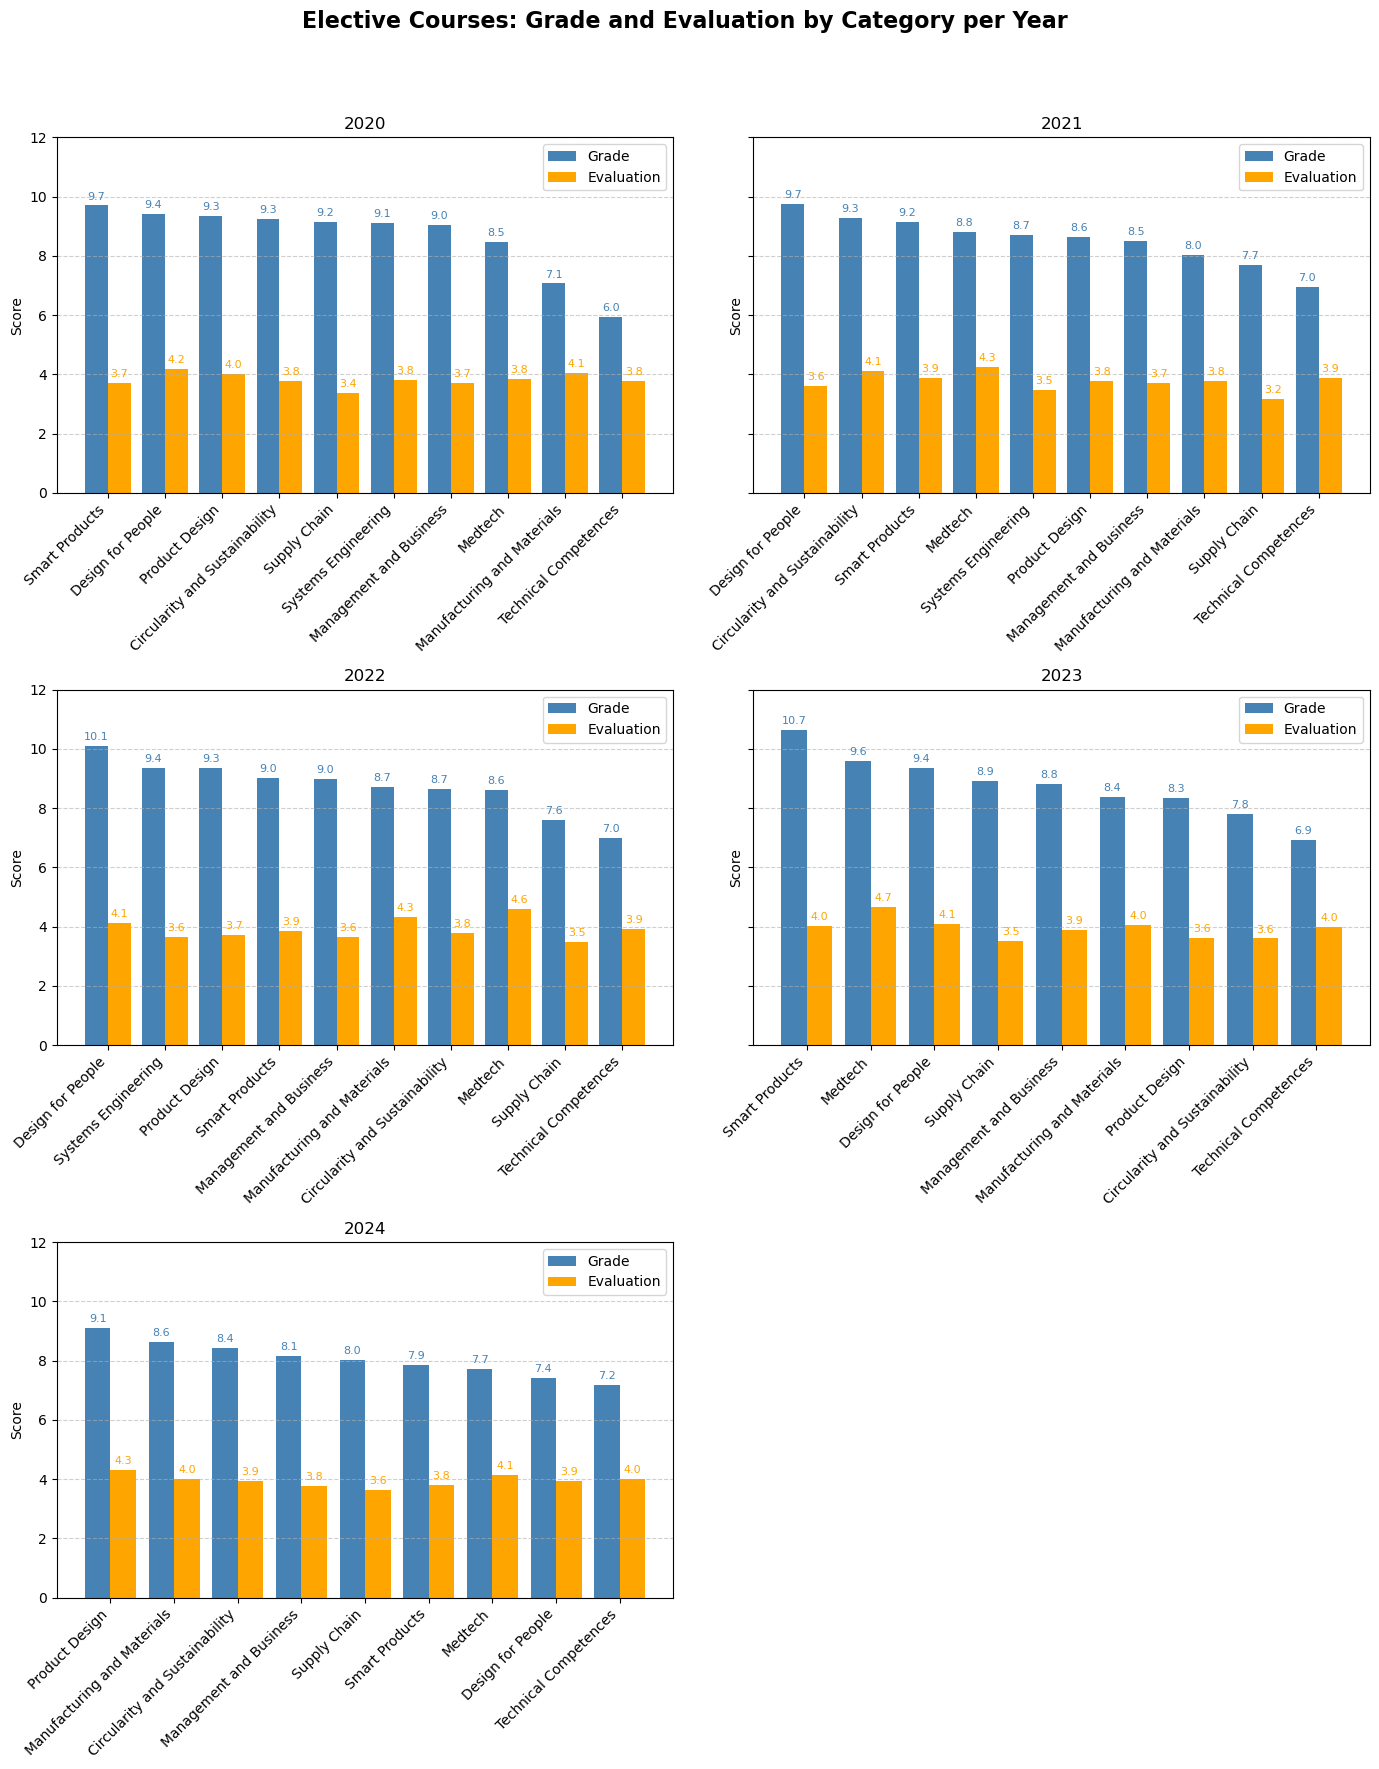

In [836]:
# Copy and filter for electives
df_n4 = CD.copy()
df_n4 = df_n4[df_n4['Course type'] == 'Elective']

# Drop rows with missing evaluations
df_n4.dropna(subset=['Eval_1.1', 'Eval_1.2', 'Eval_1.3', 'Eval_1.4', 'Eval_1.5'], inplace=True)

# Compute evaluation average
df_n4["Evaluation"] = df_n4[["Eval_1.1", "Eval_1.2", "Eval_1.3", "Eval_1.4", "Eval_1.5"]].mean(axis=1).round(2)

# Convert grades to numeric and drop incomplete rows
df_n4['Average grade'] = pd.to_numeric(df_n4['Average grade'], errors='coerce')
df_n4.dropna(subset=['Average grade', 'Evaluation'], inplace=True)

# Extract year from Semester
df_n4['Year'] = df_n4['Semester'].str.extract(r'(\d{4})')

# Handle multi-category courses
df_n4['Category'] = df_n4['Category'].astype(str).str.split(',')
df_n4 = df_n4.explode('Category')
df_n4['Category'] = df_n4['Category'].str.strip()
df_n4 = df_n4[df_n4['Category'].str.lower().isin(['', 'nan', 'none']) == False]

# Group by Category and Year
grouped = df_n4.groupby(['Year', 'Category'])[['Average grade', 'Evaluation']].mean().reset_index()

# Sort years for consistent subplot layout
years = sorted(grouped['Year'].dropna().unique())
num_years = len(years)
ncols = 2
nrows = int(np.ceil(num_years / ncols))

# Plot settings
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6 * nrows), sharey=True)
axes = axes.flatten()

for i, year in enumerate(years):
    ax = axes[i]
    data = grouped[grouped['Year'] == year].sort_values(by='Average grade', ascending=False)
    x = np.arange(len(data))
    
    bars1 = ax.bar(x - 0.2, data['Average grade'], width=0.4, label='Grade', color='steelblue')
    bars2 = ax.bar(x + 0.2, data['Evaluation'], width=0.4, label='Evaluation', color='orange')
    
    ax.set_title(f"{year}", fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(data['Category'], rotation=45, ha='right')
    ax.set_ylim(0, 12)
    ax.set_ylabel('Score')
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)
    
    # Add values above bars
    for j in range(len(data)):
        ax.text(x[j] - 0.2, data['Average grade'].iloc[j] + 0.2, f"{data['Average grade'].iloc[j]:.1f}", 
                ha='center', fontsize=8, color='steelblue')
        ax.text(x[j] + 0.2, data['Evaluation'].iloc[j] + 0.2, f"{data['Evaluation'].iloc[j]:.1f}", 
                ha='center', fontsize=8, color='orange')

    ax.legend(loc='upper right')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Elective Courses: Grade and Evaluation by Category per Year", fontsize=16,fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

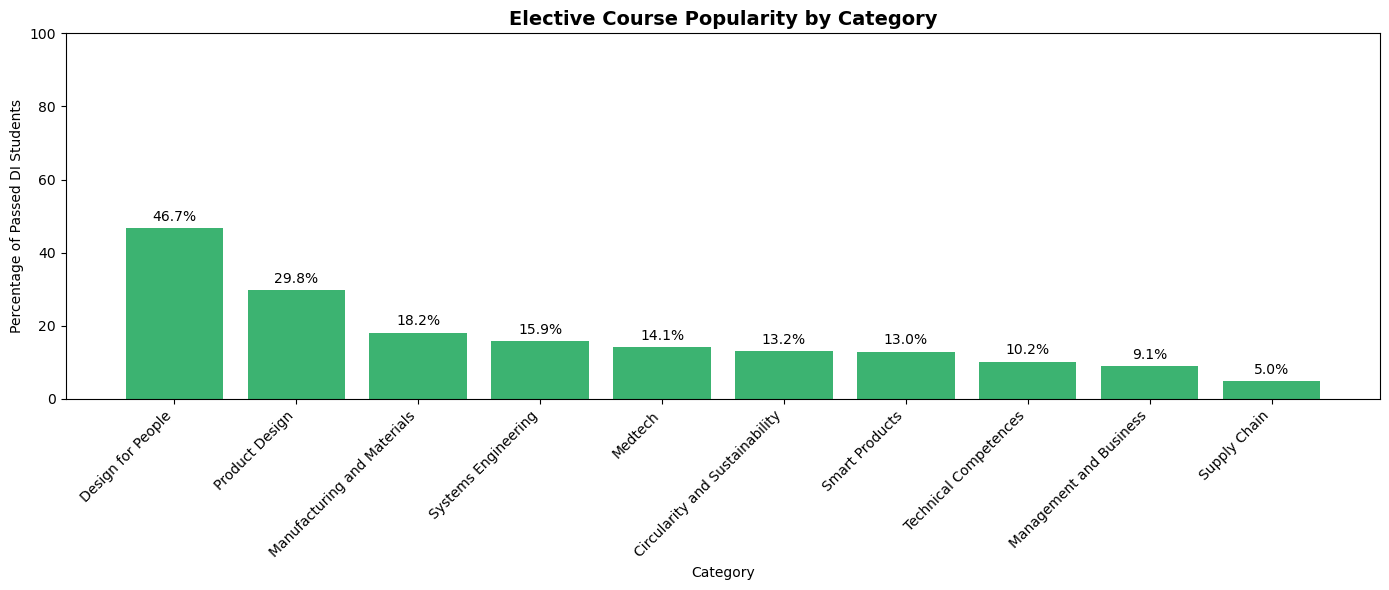

In [837]:
# Copy and filter for elective courses
df_n5 = CD.copy()
df_n5 = df_n5[df_n5['Course type'] == 'Elective']

# Ensure numeric and handle NaNs by filling with 5 where necessary
df_n5['Passed students'] = pd.to_numeric(df_n5['Passed students'], errors='coerce').fillna(5)
df_n5['Passed DI students'] = pd.to_numeric(df_n5['Passed DI students'], errors='coerce').fillna(5)

# Now set minimum of 5
df_n5.loc[df_n5['Passed students'] <= 5, 'Passed students'] = 5
df_n5.loc[df_n5['Passed DI students'] <= 5, 'Passed DI students'] = 5

# Strip category whitespace
df_n5['Category'] = df_n5['Category'].astype(str).str.strip()

# Drop rows where Category is missing or empty
df_n5 = df_n5[df_n5['Category'].str.lower().isin(['', 'nan', 'none']) == False]

# Calculate DI fraction as percentage
df_n5['DI_fraction'] = 100 * df_n5['Passed DI students'] / df_n5['Passed students']

# Group and sort
popularity_by_category = df_n5.groupby('Category')['DI_fraction'].mean().reset_index()
popularity_by_category = popularity_by_category.sort_values(by='DI_fraction', ascending=False)

# Plot
plt.figure(figsize=(14, 6))
bars = plt.bar(popularity_by_category['Category'], popularity_by_category['DI_fraction'], color='mediumseagreen')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Fraction of Passed DI Students')
plt.xlabel('Category')
plt.ylabel('Percentage of Passed DI Students')
plt.ylim(0, 100)
plt.grid(False)
plt.title('Elective Course Popularity by Category', fontsize=14,fontweight='bold')
# Annotate bars with percentage values
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    

plt.tight_layout()
plt.savefig("popularity_by_category.png", dpi=300, bbox_inches="tight")
plt.show()

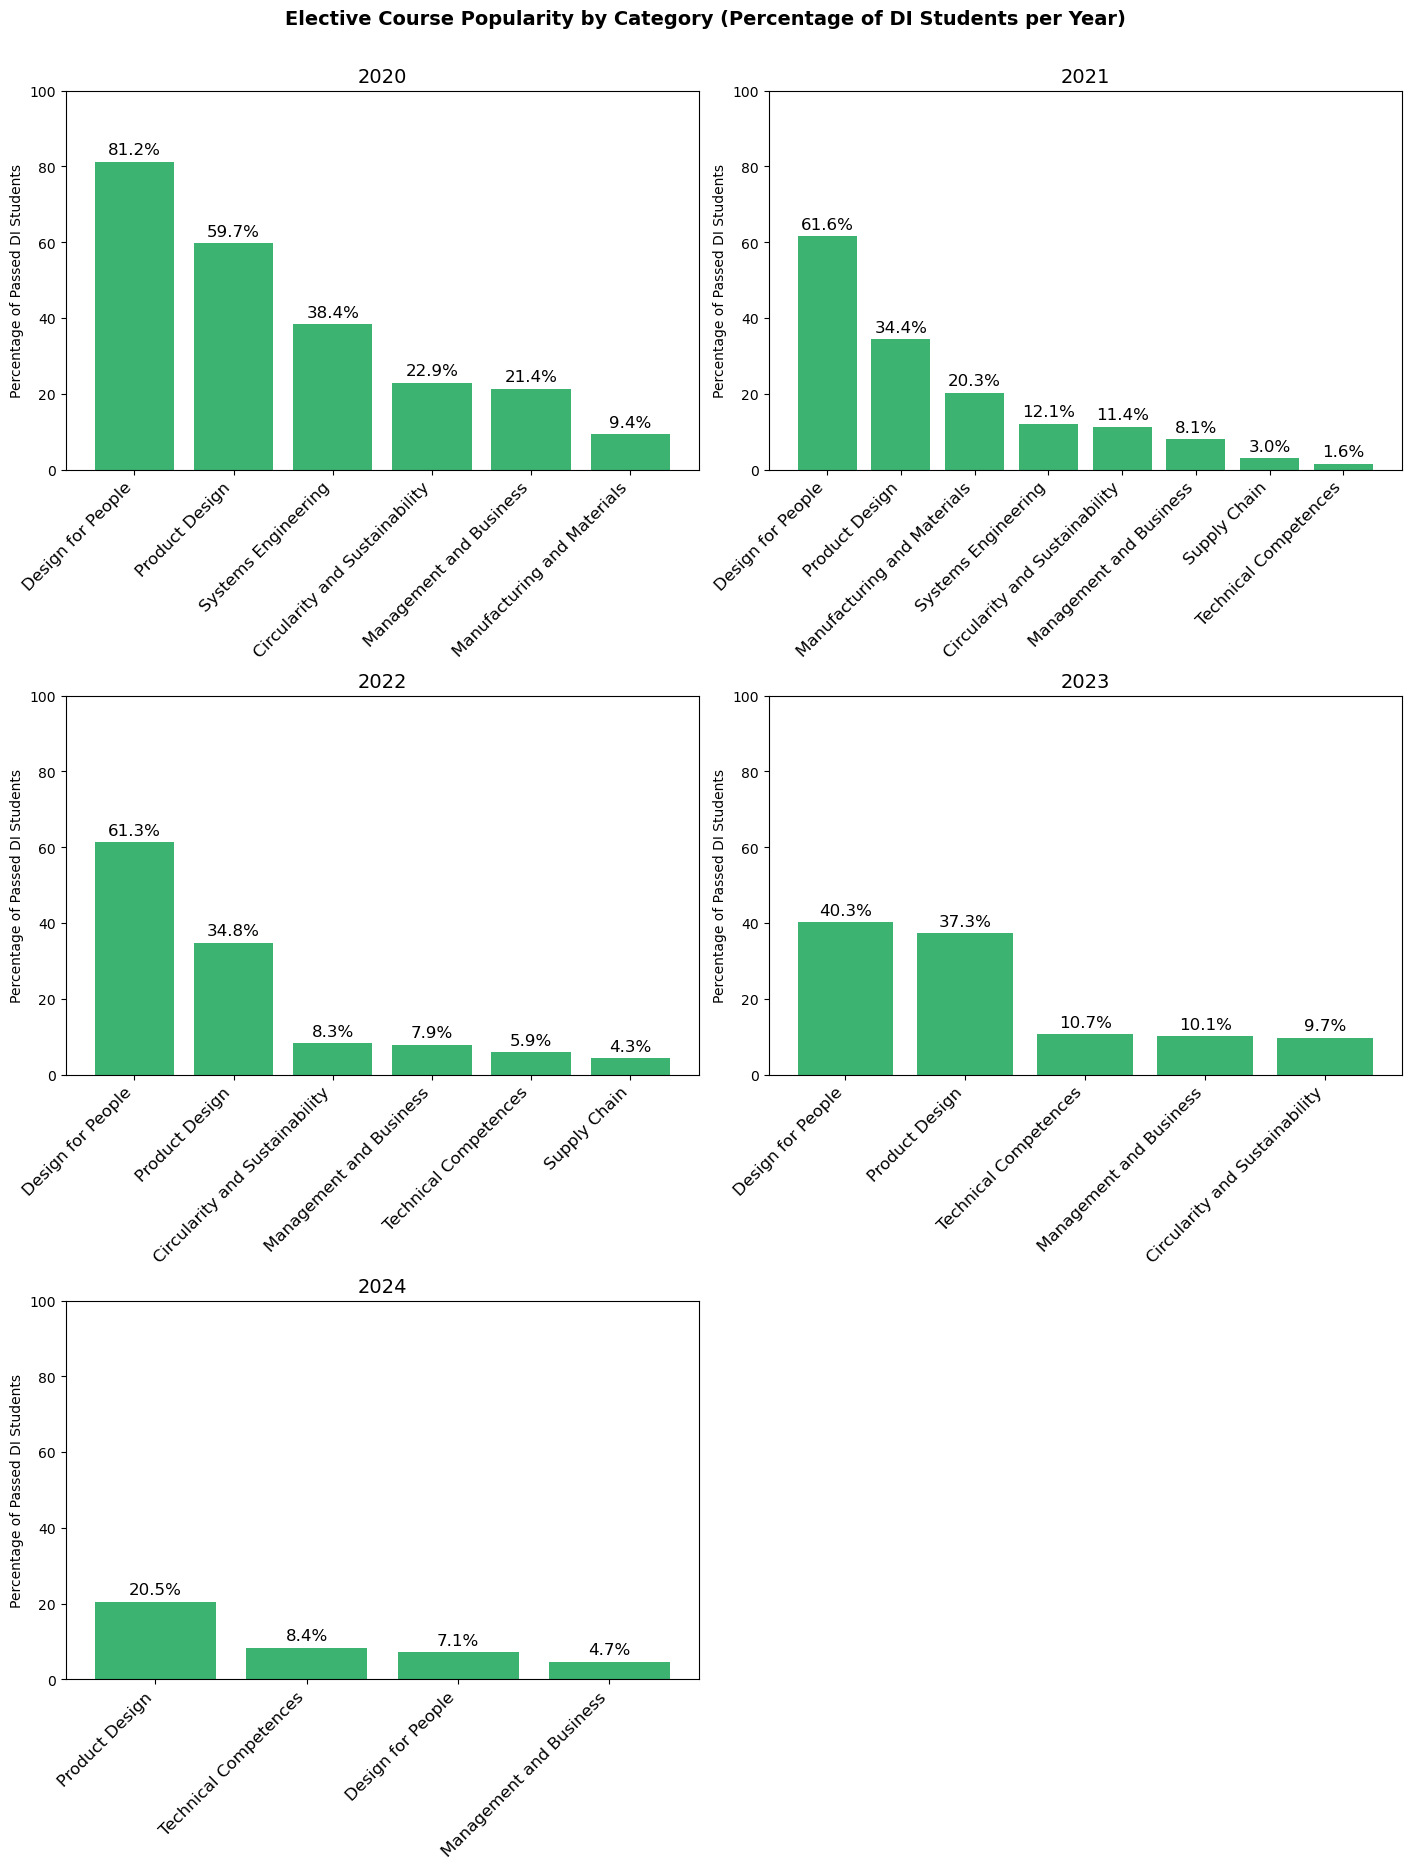

In [838]:
# Copy and filter for elective courses
df_n6 = CD.copy()
df_n6 = df_n6[df_n6['Course type'] == 'Elective']

# Convert relevant columns to numeric
df_n6['Passed students'] = pd.to_numeric(df_n6['Passed students'], errors='coerce')
df_n6['Passed DI students'] = pd.to_numeric(df_n6['Passed DI students'], errors='coerce')

# Drop rows with missing or zero values to avoid division errors
df_n6 = df_n6.dropna(subset=['Passed students', 'Passed DI students'])
df_n6 = df_n6[df_n6['Passed students'] > 0]

# Set minimum values to 5 for privacy rounding
df_n6.loc[df_n6['Passed students'] <= 5, 'Passed students'] = 5
df_n6.loc[df_n6['Passed DI students'] <= 5, 'Passed DI students'] = 5

# Calculate DI percentage
df_n6['DI_fraction'] = 100 * df_n6['Passed DI students'] / df_n6['Passed students']

# Handle multi-category courses
df_n6['Category'] = df_n6['Category'].astype(str).str.split(',')
df_n6 = df_n6.explode('Category')
df_n6['Category'] = df_n6['Category'].str.strip()
df_n6 = df_n6[df_n6['Category'].str.lower().isin(['', 'nan', 'none']) == False]

# Extract year from semester string
df_n6['Year'] = df_n6['Semester'].str.extract(r'(\d{4})')
df_n6 = df_n6.dropna(subset=['Year'])

# Prepare plot layout
years = sorted(df_n6['Year'].unique())
n_years = len(years)
n_cols = 2
n_rows = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6 * nrows), constrained_layout=True)
axes = axes.flatten()

for i, year in enumerate(years[:6]):  # Limit to first 6 years
    ax = axes[i]
    df_year = df_n6[df_n6['Year'] == year]
    summary = df_year.groupby('Category')['DI_fraction'].mean().reset_index()
    summary = summary.sort_values(by='DI_fraction', ascending=False)

    bars = ax.bar(summary['Category'], summary['DI_fraction'], color='mediumseagreen')
    ax.set_title(f'{year}', fontsize=14)
    ax.set_ylim(0, 100)
    ax.set_xticks(range(len(summary)))
    ax.set_xticklabels(summary['Category'], rotation=45, ha='right', fontsize=12)
    ax.set_ylabel("Percentage of Passed DI Students")
    ax.grid(False)

    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=12)

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Set overall title
fig.suptitle('Elective Course Popularity by Category (Percentage of DI Students per Year)', fontsize=14, y=1.03,fontweight='bold')

# Save and show
plt.savefig("popularity_by_category_yearly.png", dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

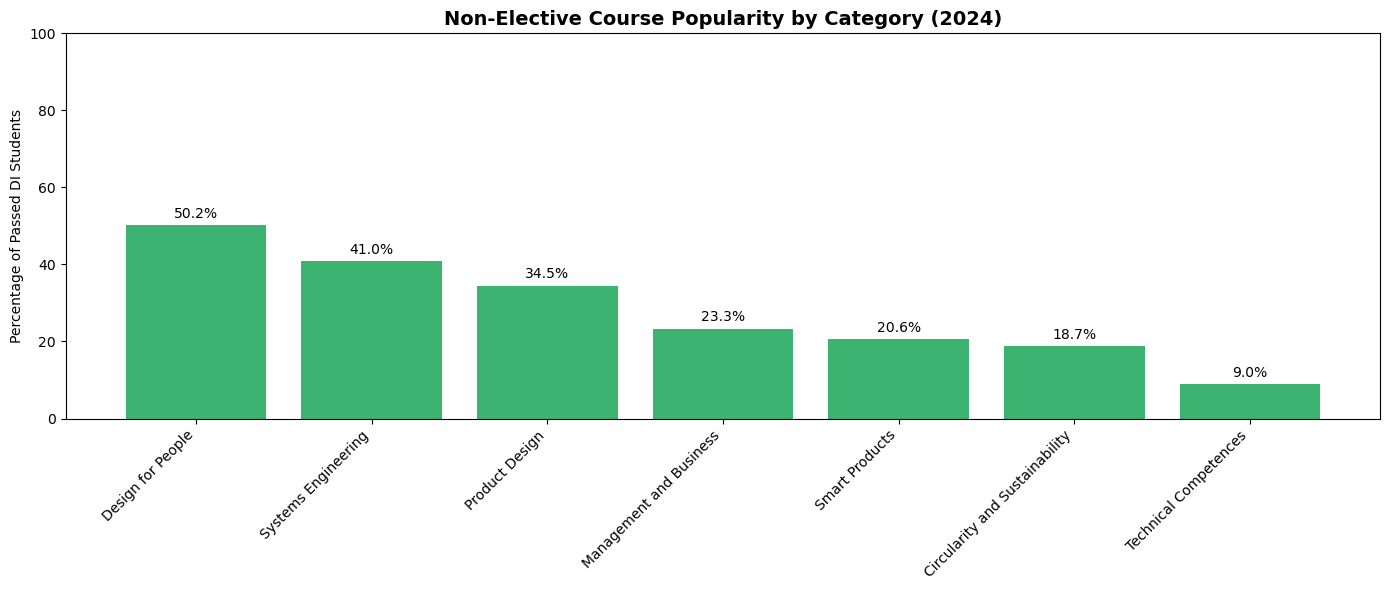

In [839]:
# Copy and exclude electives
df_n7 = CD.copy()
df_n7 = df_n7[df_n7['Course type'] != 'Elective']

# Convert columns to numeric
df_n7['Passed students'] = pd.to_numeric(df_n7['Passed students'], errors='coerce')
df_n7['Passed DI students'] = pd.to_numeric(df_n7['Passed DI students'], errors='coerce')

# Drop missing or invalid values
df_n7 = df_n7.dropna(subset=['Passed students', 'Passed DI students'])
df_n7 = df_n7[df_n7['Passed students'] > 0]

# Privacy rounding
df_n7.loc[df_n7['Passed students'] <= 5, 'Passed students'] = 5
df_n7.loc[df_n7['Passed DI students'] <= 5, 'Passed DI students'] = 5

# Calculate DI percentage
df_n7['DI_fraction'] = 100 * df_n7['Passed DI students'] / df_n7['Passed students']

# Handle multi-category courses
df_n7['Category'] = df_n7['Category'].astype(str).str.split(',')
df_n7 = df_n7.explode('Category')
df_n7['Category'] = df_n7['Category'].str.strip()
df_n7 = df_n7[df_n7['Category'].str.lower().isin(['', 'nan', 'none']) == False]

# Extract year and filter for 2024
df_n7['Year'] = df_n7['Semester'].str.extract(r'(\d{4})')
df_n7 = df_n7[df_n7['Year'] == '2024']

# Group and summarize
summary = df_n7.groupby('Category')['DI_fraction'].mean().reset_index()
summary = summary.sort_values(by='DI_fraction', ascending=False)

# Plot
plt.figure(figsize=(14, 6))
bars = plt.bar(summary['Category'], summary['DI_fraction'], color='mediumseagreen')
plt.title('Non-Elective Course Popularity by Category (2024)', fontsize=14,fontweight='bold')
plt.ylabel("Percentage of Passed DI Students")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.grid(False)
# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.savefig("popularity_by_category_2024_non_electives.png", dpi=300, bbox_inches="tight")
plt.show()

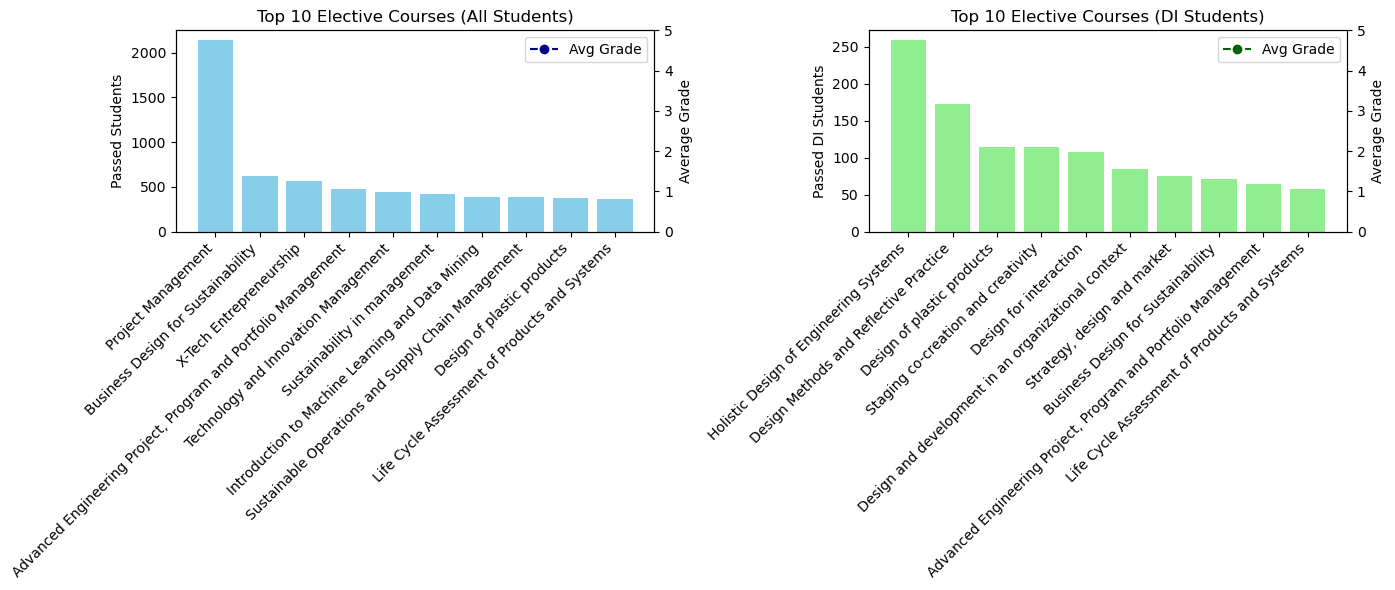

In [840]:
# Create df_n8 from CD
df_n8 = CD.copy()

# Filter for elective courses only
df_n8 = df_n8[df_n8['Course type'] == 'Elective']

# Convert relevant columns to numeric
df_n8['Passed students'] = pd.to_numeric(df_n8['Passed students'], errors='coerce')
df_n8['Passed DI students'] = pd.to_numeric(df_n8['Passed DI students'], errors='coerce')
df_n8['Average grade'] = pd.to_numeric(df_n8['Average grade'], errors='coerce')

# Drop rows with missing values
df_n8 = df_n8.dropna(subset=['Passed students', 'Passed DI students', 'Average grade'])

# Group and summarize
summary = df_n8.groupby('Course name').agg({
    'Passed students': 'sum',
    'Passed DI students': 'sum',
    'Average grade': 'mean'
}).reset_index()

# Top 10 courses by all and DI students
top_all = summary.sort_values(by='Passed students', ascending=False).head(10)
top_di = summary.sort_values(by='Passed DI students', ascending=False).head(10)

# Create consistent x positions
x_all = range(len(top_all))
x_di = range(len(top_di))

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# --- All Students Plot ---
ax1_bar = ax1
ax1_line = ax1.twinx()

ax1_bar.bar(x_all, top_all['Passed students'], color='skyblue')
ax1_line.plot(x_all, top_all['Average grade'], color='darkblue', marker='o', linestyle='--', label='Avg Grade')

ax1_bar.set_title('Top 10 Elective Courses (All Students)')
ax1_bar.set_ylabel('Passed Students')
ax1_line.set_ylabel('Average Grade')
ax1_bar.set_xticks(x_all)
ax1_bar.set_xticklabels(top_all['Course name'], rotation=45, ha='right')
ax1_line.set_ylim(0, 5)
ax1_line.legend(loc='upper right')

# --- DI Students Plot ---
ax2_bar = ax2
ax2_line = ax2.twinx()

ax2_bar.bar(x_di, top_di['Passed DI students'], color='lightgreen')
ax2_line.plot(x_di, top_di['Average grade'], color='darkgreen', marker='o', linestyle='--', label='Avg Grade')

ax2_bar.set_title('Top 10 Elective Courses (DI Students)')
ax2_bar.set_ylabel('Passed DI Students')
ax2_line.set_ylabel('Average Grade')
ax2_bar.set_xticks(x_di)
ax2_bar.set_xticklabels(top_di['Course name'], rotation=45, ha='right')
ax2_line.set_ylim(0, 5)
ax2_line.legend(loc='upper right')
ax1.grid(False)
ax2.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
# Copy and filter for elective courses
df_n9 = CD.copy()
df_n9 = df_n9[df_n9['Course type'] == 'Elective']

# Convert to numeric
df_n9['Passed DI students'] = pd.to_numeric(df_n9['Passed DI students'], errors='coerce')
df_n9['Average grade'] = pd.to_numeric(df_n9['Average grade'], errors='coerce')

# Extract year
df_n9['Year'] = df_n9['Semester'].str.extract(r'(\d{4})')
df_n9 = df_n9.dropna(subset=['Year', 'Passed DI students', 'Average grade'])
df_n9['Year'] = df_n9['Year'].astype(int)

# Set up subplots: 2 columns x 3 rows
years = sorted(df_n9['Year'].unique())
n_cols = 2
n_rows = 6

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16,6 * n_rows), constrained_layout=True)
axes = axes.flatten()

# Plot for each year
for i, year in enumerate(years[:6]):  # Limit to 6 plots
    df_year = df_n9[df_n9['Year'] == year]

    # Group by course
    summary = df_year.groupby('Course code').agg({
        'Passed DI students': 'sum',
        'Average grade': 'mean'
    }).reset_index()

    # Top 10 courses by D&I pass count
    top = summary.sort_values(by='Passed DI students', ascending=False).head(10)
    x = np.arange(len(top))

    ax1 = axes[i]
    ax2 = ax1.twinx()

    # Bar plot for D&I students
    ax1.bar(x, top['Passed DI students'], color='mediumseagreen', zorder=1)
    
    # Line plot for average grade (capture handle for legend)
    line_plot, = ax2.plot(x, top['Average grade'], color='steelblue', marker='o', 
                          linestyle='--', linewidth=2.5, zorder=3, label='Avg Grade')

    # Formatting for each subplot
    ax1.set_title(f'{year}', fontsize=14)
    ax1.set_ylabel('Passed D&I Students')
    ax2.set_ylabel('Avg Grade (0–12)')
    ax2.set_ylim(0, 12)

    ax1.set_xticks(x)
    ax1.set_xticklabels(top['Course code'], rotation=45, ha='right', fontsize=12)

    ax1.grid(False)
    ax2.grid(False)

# Remove unused subplots if fewer than 6 years
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add a single shared legend above the subplots, below the suptitle
fig.suptitle("Top 10 Elective Courses for D&I Students (By Year)", fontsize=14, y=1.03,fontweight='bold')
fig.legend([line_plot], ['Avg Grade'], loc='upper center', bbox_to_anchor=(0.5, 1.015), ncol=1, frameon=False)

# Save and show the figure
plt.savefig("top_10_electives.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
df9 = CD.copy()

# Drop rows with any missing evaluation components
df9.dropna(subset=['Eval_1.1', 'Eval_1.2', 'Eval_1.3', 'Eval_1.4', 'Eval_1.5'], inplace=True)

eval_cols = ['Eval_1.1', 'Eval_1.2', 'Eval_1.3', 'Eval_1.4', 'Eval_1.5', 'Eval_2.1']
custom_titles = [
    "I have learnt alot",
    "Activities correspond with learning opjective",
    "Are activities motivating",
    "Feedback Quality",
    "Clear expectation",
    "Workload"
]
# Set up the matplotlib figure with 5 subplots (can be horizontal or vertical)
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(17,25 ), sharex=False)

# Plot each evaluation column
for ax, col, title in zip(axes, eval_cols, custom_titles):
    sns.boxplot(data=df9, x='Category', y=col, ax=ax, showmeans=True,
                meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "black"}, palette=["mediumseagreen"])
                
    ax.set_title(title)
    ax.set_xlabel("Category")
    ax.set_ylabel("Score")
    ax.set_ylim(0, 5)

plt.tight_layout()
plt.show()